In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
proj_dir = Path("../..")

In [3]:
mcn_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_MCN.csv")
prd_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_PRD.csv")
wan_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_WAN.csv")
ris_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_RIS.csv")
pro_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_PRO.csv")
ihr_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_IHR.csv")
lmn_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_LMN.csv")
lgs_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_LGS.csv")
lwg_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_LWG.csv")
jda_fish_df = pd.read_csv(proj_dir / "Data/insitu/fish/processed/DART_JDA.csv")

In [4]:
run_schedules = {
    "mcnary": {
        "spring": ["04-01", "06-08"],
        "summer": ["06-09", "08-08"],
        "fall": ["08-09", "10-31"],
    },
    "priest_rapids": {
        "spring": ["04-15", "06-13"],
        "summer": ["06-14", "08-13"],
        "fall": ["08-14", "11-15"],
    },
    "prosser": {"spring": ["03-01", "08-15"], "fall": ["08-16", "12-15"]},
    "ice_harbor": {
        "spring": ["04-01", "06-11"],
        "summer": ["06-12", "08-11"],
        "fall": ["08-12", "12-15"],
    },
    "lower_monumental": {
        "spring": ["04-01", "06-11"],
        "summer": ["06-14", "08-13"],
        "fall": ["08-14", "10-31"],
    },
    "little_goose": {
        "spring": ["04-01", "06-13"],
        "summer": ["06-16", "08-15"],
        "fall": ["08-16", "10-31"],
    },
    "lower_granite": {
        "spring": ["03-01", "06-17"],
        "summer": ["06-18", "08-17"],
        "fall": ["08-18", "12-15"],
    },
    "rock_island": {
        "spring": ["04-14", "06-17"],
        "summer": ["06-18", "08-17"],
        "fall": ["08-18", "11-14"],
    },
    "john_day": {
        "spring": ["04-01", "06-05"],
        "summer": ["06-06", "08-05"],
        "fall": ["08-06", "10-31"],
    },
}

In [5]:
# allocate run schedules to each fish data frame
def allocate_runs(df, run_schedule):
    df_copy = df.copy()
    df_copy["year"] = df_copy["date"].dt.year
    for run, dates in run_schedule.items():
        for year in df_copy["year"].unique():
            start_date = pd.Timestamp(f"{year}-{dates[0]}")
            end_date = pd.Timestamp(f"{year}-{dates[1]}")
            df_copy.loc[
                (df_copy["date"] >= start_date) & (df_copy["date"] <= end_date), "run"
            ] = run
        df_copy = pd.concat(
            [
                df_copy,
                pd.DataFrame(
                    {
                        "run": run,
                        "year": df_copy["year"].unique(),
                    }
                ),
            ]
        )
    return df_copy

In [6]:
def post_process(df, name):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["doy"] = df["date"].dt.dayofyear

    df = allocate_runs(df, run_schedules[name])

    return df

In [7]:
mcn_fish_df = post_process(mcn_fish_df, "mcnary")
prd_fish_df = post_process(prd_fish_df, "priest_rapids")
wan_fish_df = post_process(wan_fish_df, "rock_island")
ris_fish_df = post_process(ris_fish_df, "rock_island")
pro_fish_df = post_process(pro_fish_df, "prosser")
ihr_fish_df = post_process(ihr_fish_df, "ice_harbor")
lmn_fish_df = post_process(lmn_fish_df, "lower_monumental")
lgs_fish_df = post_process(lgs_fish_df, "little_goose")
lwg_fish_df = post_process(lwg_fish_df, "lower_granite")
jda_fish_df = post_process(jda_fish_df, "john_day")

In [8]:
prd_conditions_df = pd.read_csv(proj_dir / "Data/insitu/conditions/processed/DART_PRD.csv")
prd_conditions_df["date"] = pd.to_datetime(prd_conditions_df["date"])
prd_conditions_df_weekly = prd_conditions_df.resample("W", on="date").mean().reset_index()

In [9]:
def plot_stacked_run_counts(df, ax, title, species="chinook"):

    bottom = np.zeros(len(df["year"].unique()))
    for run, group in df.fillna(0).groupby("run"):
        if run != 0:
            year_group = group.groupby("year")[species].sum().reset_index()
            # fig, ax = plt.subplots()
            p = ax.bar(
                year_group["year"], year_group[species], label=run, bottom=bottom
            )
            # print(group.groupby("year")[species].sum().reset_index())
            bottom += group.groupby("year")[species].sum()
    ax.set_title(title)
    ax.legend()

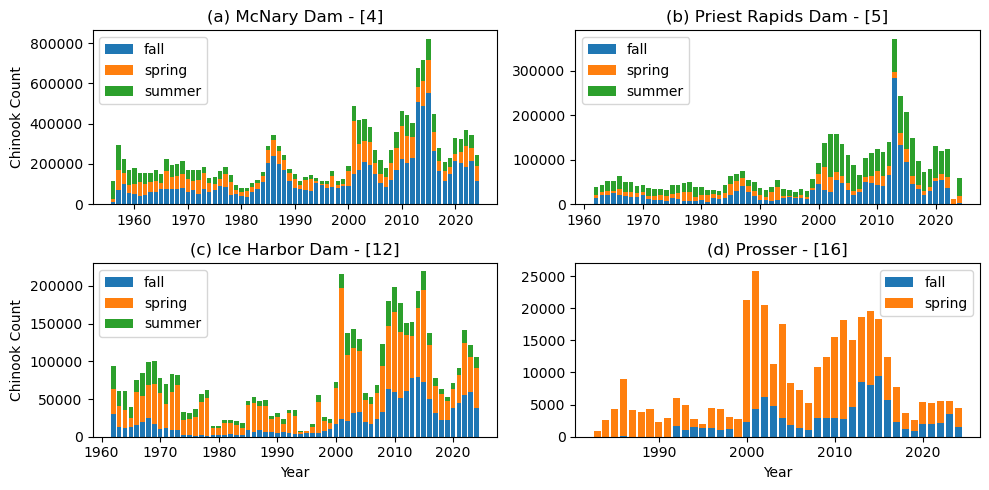

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
plot_stacked_run_counts(mcn_fish_df, axs[0, 0], "(a) McNary Dam - [4]")
plot_stacked_run_counts(prd_fish_df, axs[0, 1], "(b) Priest Rapids Dam - [5]")
plot_stacked_run_counts(ihr_fish_df, axs[1, 0], "(c) Ice Harbor Dam - [12]")
plot_stacked_run_counts(pro_fish_df, axs[1, 1], "(d) Prosser - [16]")

axs[0, 0].set_ylabel("Chinook Count")
axs[1, 0].set_ylabel("Chinook Count")

axs[1, 0].set_xlabel("Year")
axs[1, 1].set_xlabel("Year")

fig.tight_layout()
fig.savefig(proj_dir / "methods/02-fish_mass_bal/stacked_run_counts.png", dpi=600)

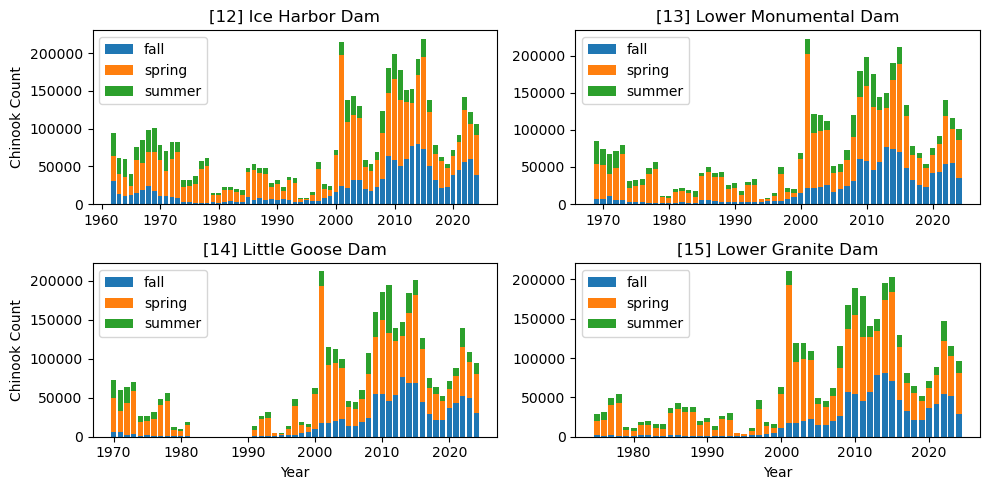

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
plot_stacked_run_counts(ihr_fish_df, axs[0, 0], "[12] Ice Harbor Dam")
plot_stacked_run_counts(lmn_fish_df, axs[0, 1], "[13] Lower Monumental Dam")
plot_stacked_run_counts(lgs_fish_df, axs[1, 0], "[14] Little Goose Dam")
plot_stacked_run_counts(lwg_fish_df, axs[1, 1], "[15] Lower Granite Dam")

axs[0, 0].set_ylabel("Chinook Count")
axs[1, 0].set_ylabel("Chinook Count")

axs[1, 0].set_xlabel("Year")
axs[1, 1].set_xlabel("Year")

fig.tight_layout()

# Chinook population in the Hanford Reach

Using the concept of control volume to assess the adult migration and population in the Hanford reach.  
Adult Chinook entering the reach:  
* McNary Dam: $Ch_{4}$

Adult Chinook exiting the reach:  
* Priest Rapids Dam: $Ch_{5}$
* Ice Harbor Dam: $Ch_{12}$
* Proser: $Ch_{16}$

Adult Chinook population in the reach:
* Hanford Reach: $Ch_{hr}$

Change in adult chinook population in the reach ($\Delta Ch_{hr}$):  
* $\Delta Ch_{hr} = Ch_{4} - Ch_{5} - Ch_{12} - Ch_{16}$

In [12]:
mcnary_chinook_df = mcn_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()
priest_rapids_chinook_df = prd_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()
prosser_chinook_df = pro_fish_df[
    ["date", "year", "month", "day", "chinook", "run"]
].copy()
ice_harbor_chinook_df = ihr_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()

In [13]:
yearly_spring_chinook = (
    mcnary_chinook_df[(mcnary_chinook_df["run"] == "spring")]
    .groupby("year")["chinook"]
    .sum()
    .reset_index()
    .rename(columns={"chinook": "mcnary"})
    .merge(
        priest_rapids_chinook_df[(priest_rapids_chinook_df["run"] == "spring")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "priest_rapids"}),
        on="year",
        how="outer",
    )
    .merge(
        prosser_chinook_df[(prosser_chinook_df["run"] == "spring")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "prosser"}),
        on="year",
        how="outer",
    )
    .merge(
        ice_harbor_chinook_df[(ice_harbor_chinook_df["run"] == "spring")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "ice_harbor"}),
        on="year",
        how="outer",
    )
)


# yearly_spring_chinook = yearly_spring_chinook[
#     (yearly_spring_chinook["year"] >= 2000) & (yearly_spring_chinook["year"] <= 2022)
# ]
yearly_spring_chinook["delta"] = (
    yearly_spring_chinook["mcnary"]
    - yearly_spring_chinook["priest_rapids"]
    - yearly_spring_chinook["prosser"]
    - yearly_spring_chinook["ice_harbor"]
)
yearly_spring_chinook["percent_delta"] = (
    yearly_spring_chinook["delta"] / yearly_spring_chinook["mcnary"]
)

In [14]:
yearly_summer_chinook = (
    mcnary_chinook_df[(mcnary_chinook_df["run"] == "summer")]
    .groupby("year")["chinook"]
    .sum()
    .reset_index()
    .rename(columns={"chinook": "mcnary"})
    .merge(
        priest_rapids_chinook_df[(priest_rapids_chinook_df["run"] == "summer")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "priest_rapids"}),
        on="year",
        how="outer",
    )
    .merge(
        ice_harbor_chinook_df[(ice_harbor_chinook_df["run"] == "summer")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "ice_harbor"}),
        on="year",
        how="outer",
    )
)

# yearly_summer_chinook = yearly_summer_chinook[
#     (yearly_summer_chinook["year"] >= 2000) & (yearly_summer_chinook["year"] <= 2022)
# ]
yearly_summer_chinook["delta"] = (
    yearly_summer_chinook["mcnary"]
    - yearly_summer_chinook["priest_rapids"]
    - yearly_summer_chinook["ice_harbor"]
)
yearly_summer_chinook["percent_delta"] = (
    yearly_summer_chinook["delta"] / yearly_summer_chinook["mcnary"]
)

In [15]:
yearly_fall_chinook = (
    mcnary_chinook_df[(mcnary_chinook_df["run"] == "fall")]
    .groupby("year")["chinook"]
    .sum()
    .reset_index()
    .rename(columns={"chinook": "mcnary"})
    .merge(
        priest_rapids_chinook_df[(priest_rapids_chinook_df["run"] == "fall")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "priest_rapids"}),
        on="year",
        how="outer",
    )
    .merge(
        prosser_chinook_df[(prosser_chinook_df["run"] == "fall")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "prosser"}),
        on="year",
        how="outer",
    )
    .merge(
        ice_harbor_chinook_df[(ice_harbor_chinook_df["run"] == "fall")]
        .groupby("year")["chinook"]
        .sum()
        .reset_index()
        .rename(columns={"chinook": "ice_harbor"}),
        on="year",
        how="outer",
    )
)

# yearly_fall_chinook = yearly_fall_chinook[
#     (yearly_fall_chinook["year"] >= 2000) & (yearly_fall_chinook["year"] <= 2022)
# ]
yearly_fall_chinook["delta"] = (
    yearly_fall_chinook["mcnary"]
    - yearly_fall_chinook["priest_rapids"]
    - yearly_fall_chinook["prosser"]
    - yearly_fall_chinook["ice_harbor"]
)
yearly_fall_chinook["percent_delta"] = (
    yearly_fall_chinook["delta"] / yearly_fall_chinook["mcnary"]
)

<Axes: title={'center': 'Summer Chinook Delta'}, xlabel='year'>

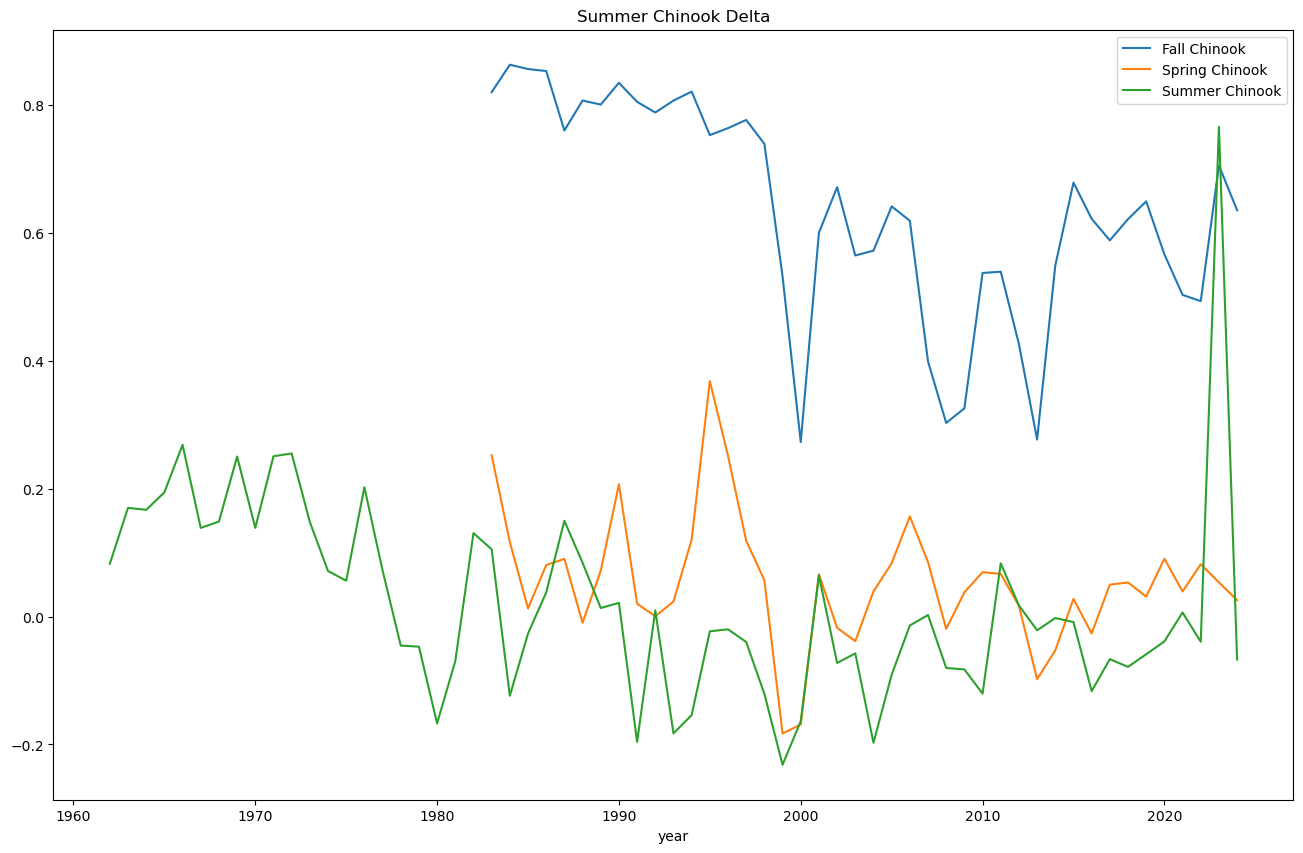

In [16]:
fig, ax = plt.subplots(figsize=(16, 10))
yearly_fall_chinook.plot(x="year", y="percent_delta", title="Fall Chinook Delta", ax=ax, label="Fall Chinook")
yearly_spring_chinook.plot(x="year", y="percent_delta", title="Spring Chinook Delta", ax=ax, label="Spring Chinook")
yearly_summer_chinook.plot(x="year", y="percent_delta", title="Summer Chinook Delta", ax=ax, label="Summer Chinook")

In [17]:
hanford_chinook_df = (
    mcnary_chinook_df[(mcnary_chinook_df["run"] == "fall")][["date", "chinook"]]
    .rename(columns={"chinook": "mcnary"})
    .merge(
        priest_rapids_chinook_df[(priest_rapids_chinook_df["run"] == "fall")][
            ["date", "chinook"]
        ].rename(columns={"chinook": "priest_rapids"}),
        on="date",
        how="outer",
    )
    .merge(
        prosser_chinook_df[(prosser_chinook_df["run"] == "fall")][
            ["date", "chinook"]
        ].rename(columns={"chinook": "prosser"}),
        on="date",
        how="outer",
    )
    .merge(
        ice_harbor_chinook_df[(ice_harbor_chinook_df["run"] == "fall")][
            ["date", "chinook"]
        ].rename(columns={"chinook": "ice_harbor"}),
        on="date",
        how="outer",
    )
    .copy()
)
hanford_chinook_df["year"] = hanford_chinook_df["date"].dt.year
hanford_chinook_df[["mcnary", "priest_rapids", "prosser", "ice_harbor"]] = (
    hanford_chinook_df[["mcnary", "priest_rapids", "prosser", "ice_harbor"]]
    .copy()
    .fillna(0)
)

hanford_chinook_df["priest_rapids"] = hanford_chinook_df["priest_rapids"].shift(-5)
hanford_chinook_df["prosser"] = hanford_chinook_df["prosser"].shift(-7)
hanford_chinook_df["ice_harbor"] = hanford_chinook_df["ice_harbor"].shift(-3)


hanford_chinook_df["delta"] = (
    hanford_chinook_df["mcnary"]
    - hanford_chinook_df["priest_rapids"]
    - hanford_chinook_df["prosser"]
    - hanford_chinook_df["ice_harbor"]
)
hanford_chinook_df.dropna(subset=["year"], inplace=True)

In [18]:
years = hanford_chinook_df["year"].unique()
# sort out the years
years = np.sort(years)
years

array([1956., 1957., 1958., 1959., 1960., 1961., 1962., 1963., 1964.,
       1965., 1966., 1967., 1968., 1969., 1970., 1971., 1972., 1973.,
       1974., 1975., 1976., 1977., 1978., 1979., 1980., 1981., 1982.,
       1983., 1984., 1985., 1986., 1987., 1988., 1989., 1990., 1991.,
       1992., 1993., 1994., 1995., 1996., 1997., 1998., 1999., 2000.,
       2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
       2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018.,
       2019., 2020., 2021., 2022., 2023., 2024.])

In [19]:
_hanford_chinook_df = hanford_chinook_df.resample("W", on="date").sum().reset_index()
_hanford_chinook_df

,date,mcnary,priest_rapids,prosser,ice_harbor,year,delta
0,1956-08-12,1267.0,0.0,0.0,0.0,7824.0,1267.0
1,1956-08-19,1533.0,0.0,0.0,0.0,13692.0,1533.0
2,1956-08-26,734.0,0.0,0.0,0.0,13692.0,734.0
3,1956-09-02,460.0,0.0,0.0,0.0,13692.0,460.0
4,1956-09-09,1114.0,0.0,0.0,0.0,13692.0,1114.0
...,...,...,...,...,...,...,...
3550,2024-08-25,8960.0,1453.0,567.0,7379.0,14168.0,-439.0
3551,2024-09-01,17815.0,0.0,166.0,10870.0,14168.0,6779.0
3552,2024-09-08,31716.0,0.0,127.0,8957.0,14168.0,22632.0
3553,2024-09-15,37770.0,0.0,95.0,6700.0,14168.0,30975.0


In [20]:
thorr_df = pd.read_csv(proj_dir / "data/thorr/thorr_temp.csv")
thorr_df["date"] = pd.to_datetime(thorr_df["Date"])
columbia_df = thorr_df[thorr_df["RiverID"] == 9].copy()
snake_df = thorr_df[thorr_df["RiverID"] == 45].copy()
yakima_df = thorr_df[thorr_df["RiverID"] == 58].copy()
# thorr_df = thorr_df[thorr_df['RiverID'] == 9].copy()

In [21]:
# group columbia by reach
grouped_columbia = columbia_df.groupby("RKm")

_merged_columbia = pd.DataFrame(columns=["date"])
for group in grouped_columbia:
    resampled = group[1].resample("W", on="date").mean(numeric_only=True).reset_index()
    # print(resampled)
    resampled.rename(columns={"EstTempC": resampled["RKm"].iloc[0]}, inplace=True)
    _merged_columbia = pd.merge(
        _merged_columbia,
        resampled[["date", resampled["RKm"].iloc[0]]],
        on="date",
        how="outer",
    )

_merged_columbia["date"] = pd.to_datetime(_merged_columbia["date"])

# make date the index
_merged_columbia.set_index("date", inplace=True)
# sort by date
_merged_columbia.sort_index(inplace=True)

# group snake by reach
grouped_snake = snake_df.groupby("RKm")

_merged_snake = pd.DataFrame(columns=["date"])
for group in grouped_snake:
    resampled = group[1].resample("W", on="date").mean(numeric_only=True).reset_index()
    # print(resampled)
    resampled.rename(columns={"EstTempC": resampled["RKm"].iloc[0]}, inplace=True)
    _merged_snake = pd.merge(
        _merged_snake,
        resampled[["date", resampled["RKm"].iloc[0]]],
        on="date",
        how="outer",
    )

_merged_snake["date"] = pd.to_datetime(_merged_snake["date"])

# make date the index
_merged_snake.set_index("date", inplace=True)
# sort by date
_merged_snake.sort_index(inplace=True)

# group yakima by reach
grouped_yakima = yakima_df.groupby("RKm")

_merged_yakima = pd.DataFrame(columns=["date"])
for group in grouped_yakima:
    resampled = group[1].resample("W", on="date").mean(numeric_only=True).reset_index()
    # print(resampled)
    resampled.rename(columns={"EstTempC": resampled["RKm"].iloc[0]}, inplace=True)
    _merged_yakima = pd.merge(
        _merged_yakima,
        resampled[["date", resampled["RKm"].iloc[0]]],
        on="date",
        how="outer",
    )

_merged_yakima["date"] = pd.to_datetime(_merged_yakima["date"])

# make date the index
_merged_yakima.set_index("date", inplace=True)
# sort by date
_merged_yakima.sort_index(inplace=True)

In [22]:
_hanford_temp_df = _merged_columbia[range(460, 630, 10)].reset_index()
_hanford_temp_df["mean_temp"] = _hanford_temp_df.drop(columns=["date"]).mean(axis=1)
_hanford_chinook_df = _hanford_chinook_df.merge(_hanford_temp_df, on="date", how="left")
_hanford_chinook_df = allocate_runs(_hanford_chinook_df, run_schedules["mcnary"])

In [23]:
_up_priest_rapids = _merged_columbia[range(640, 670, 10)].reset_index()
_up_priest_rapids["mean_temp_up"] = _up_priest_rapids.drop(columns=["date"]).mean(axis=1)
_up_priest_rapids = allocate_runs(_up_priest_rapids, run_schedules["mcnary"])
_up_priest_rapids.dropna(
    subset=[
        "mean_temp_up",
    ]
).to_csv("up_priest_rapids.csv", index=False)

In [24]:
combined_han_pri = _hanford_chinook_df.merge(_up_priest_rapids, on="date", how="left")

In [25]:
combined_han_pri["temp_gradient"] = (
    combined_han_pri["mean_temp"] - combined_han_pri["mean_temp_up"]
)

In [26]:
combined_han_pri = combined_han_pri.dropna(subset=["temp_gradient"]).copy()
combined_han_pri["date"] = pd.to_datetime(combined_han_pri["date"])

In [27]:
combined_han_pri.to_csv("combined_han_pri.csv")

In [28]:
combined_han_pri

,date,mcnary,priest_rapids,prosser,ice_harbor,year_x,delta,460.0,470.0,480.0,...,620.0,mean_temp,run_x,640.0,650.0,660.0,mean_temp_up,year_y,run_y,temp_gradient
1371,1982-11-21,0.0,49.0,0.0,0.0,1982,-49.0,NaN,NaN,NaN,...,11.280,11.308000,NaN,NaN,11.23,11.09,11.160000,1982.0,NaN,0.148000
1376,1982-12-26,0.0,0.0,0.0,0.0,1982,0.0,NaN,NaN,NaN,...,NaN,6.260000,NaN,NaN,5.87,NaN,5.870000,1982.0,NaN,0.390000
1409,1983-08-14,722.0,616.0,0.0,40.0,1983,66.0,20.99,20.97,21.010,...,19.770,20.777059,fall,19.730,19.56,19.84,19.710000,1983.0,fall,1.067059
1446,1984-04-29,0.0,0.0,0.0,0.0,1984,0.0,NaN,NaN,NaN,...,8.180,8.575000,spring,8.050,8.09,8.18,8.106667,1984.0,spring,0.468333
1447,1984-05-06,0.0,0.0,0.0,0.0,1984,0.0,10.96,11.15,11.210,...,9.200,10.332500,spring,9.250,9.76,9.59,9.533333,1984.0,spring,0.799167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,2024-08-11,932.0,352.0,302.0,1077.0,2024,-799.0,NaN,NaN,NaN,...,21.350,21.388750,fall,21.000,21.26,20.63,20.963333,2024.0,fall,0.425417
3549,2024-08-18,3792.0,765.0,214.0,3266.0,2024,-453.0,21.62,20.46,21.260,...,21.430,20.957812,fall,21.290,21.30,20.61,21.066667,2024.0,fall,-0.108854
3550,2024-08-25,8960.0,1453.0,567.0,7379.0,2024,-439.0,21.65,21.36,21.065,...,21.265,21.052059,fall,20.415,21.36,20.80,20.858333,2024.0,fall,0.193725
3551,2024-09-01,17815.0,0.0,166.0,10870.0,2024,6779.0,20.80,20.91,20.860,...,20.590,20.598235,fall,20.035,20.53,20.32,20.295000,2024.0,fall,0.303235


In [29]:
combined_han_pri[["mean_temp", "mean_temp_up", "temp_gradient"]]

,mean_temp,mean_temp_up,temp_gradient
1371,11.308000,11.160000,0.148000
1376,6.260000,5.870000,0.390000
1409,20.777059,19.710000,1.067059
1446,8.575000,8.106667,0.468333
1447,10.332500,9.533333,0.799167
...,...,...,...
3548,21.388750,20.963333,0.425417
3549,20.957812,21.066667,-0.108854
3550,21.052059,20.858333,0.193725
3551,20.598235,20.295000,0.303235


In [30]:
_hanford_chinook_df.dropna(subset=["date"], inplace=True)

Text(0, 0.5, 'Change in Chinook Population')

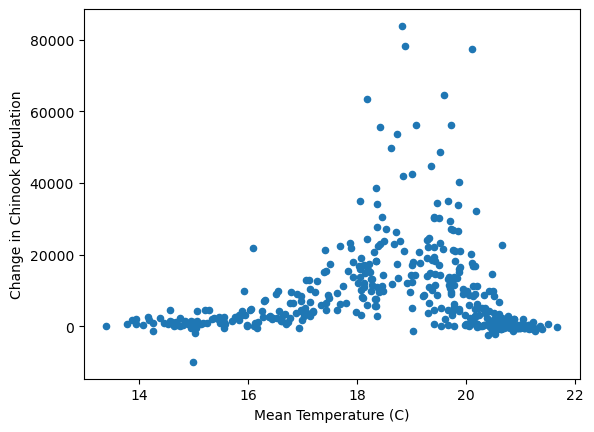

In [31]:
fig, ax = plt.subplots()
_hanford_chinook_df[_hanford_chinook_df["run"] == "fall"].plot.scatter(
    x="mean_temp",
    y="delta",
    ax=ax,
    # c='year',
    # cmap='viridis'
)
ax.set_xlabel("Mean Temperature (C)")
ax.set_ylabel("Change in Chinook Population")

In [32]:
_hanford_chinook_df.to_csv("hanford_chinook_mass_bal.csv", index=False)

In [33]:
_hanford_chinook_df.dropna(subset=["mean_temp", "delta"])

,date,mcnary,priest_rapids,prosser,ice_harbor,year,delta,460.0,470.0,480.0,...,550.0,560.0,570.0,580.0,590.0,600.0,610.0,620.0,mean_temp,run
1371,1982-11-21,0.0,49.0,0.0,0.0,1982,-49.0,NaN,NaN,NaN,...,NaN,NaN,11.340,11.350,11.240,NaN,11.330,11.280,11.308000,NaN
1372,1982-11-28,0.0,0.0,0.0,0.0,1982,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.670000,NaN
1376,1982-12-26,0.0,0.0,0.0,0.0,1982,0.0,NaN,NaN,NaN,...,NaN,6.17,NaN,NaN,6.350,NaN,NaN,NaN,6.260000,NaN
1382,1983-02-06,0.0,0.0,0.0,0.0,1983,0.0,3.26,3.22,3.340,...,3.37,3.34,NaN,3.070,3.530,3.240,3.430,3.200,3.345000,NaN
1409,1983-08-14,722.0,616.0,0.0,40.0,1983,66.0,20.99,20.97,21.010,...,21.25,20.86,20.430,20.530,20.500,19.820,20.250,19.770,20.777059,fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,2024-08-11,932.0,352.0,302.0,1077.0,2024,-799.0,NaN,NaN,NaN,...,NaN,NaN,21.510,21.170,21.440,21.550,21.670,21.350,21.388750,fall
3549,2024-08-18,3792.0,765.0,214.0,3266.0,2024,-453.0,21.62,20.46,21.260,...,20.95,20.55,NaN,21.690,20.880,20.690,21.050,21.430,20.957812,fall
3550,2024-08-25,8960.0,1453.0,567.0,7379.0,2024,-439.0,21.65,21.36,21.065,...,21.95,21.24,20.735,21.005,20.945,21.170,20.525,21.265,21.052059,fall
3551,2024-09-01,17815.0,0.0,166.0,10870.0,2024,6779.0,20.80,20.91,20.860,...,20.76,20.77,20.855,20.330,20.415,20.325,20.350,20.590,20.598235,fall


In [34]:
_hanford_chinook_df.dropna(subset=["mean_temp", "delta"]).to_csv(
    "hanford_chinook_mass_bal_no_na.csv", index=False
)

In [35]:
_hanford_chinook_df["delta_ratio"] = (
    _hanford_chinook_df["delta"] / _hanford_chinook_df["mcnary"]
)

In [36]:
_hanford_chinook_df['year']

0       1956
1       1956
2       1956
3       1956
4       1956
        ... 
3550    2024
3551    2024
3552    2024
3553    2024
3554    2024
Name: year, Length: 3555, dtype: int64

In [37]:
# assign 5-year categories from 2000 to 2022
interval = 1
_hanford_chinook_df["group_5_year"] = pd.cut(
    _hanford_chinook_df["year"],
    bins=range(1985, 2025, interval),
    # labels=[f"{x}-{x+interval-1}" for x in range(1985, 2023, interval)][:-1],
    labels=[f"{x}" for x in range(1985, 2025, interval)][:-1],
)

In [38]:
_hanford_chinook_df

,date,mcnary,priest_rapids,prosser,ice_harbor,year,delta,460.0,470.0,480.0,...,570.0,580.0,590.0,600.0,610.0,620.0,mean_temp,run,delta_ratio,group_5_year
0,1956-08-12,1267.0,0.0,0.0,0.0,1956,1267.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall,1.000000,NaN
1,1956-08-19,1533.0,0.0,0.0,0.0,1956,1533.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall,1.000000,NaN
2,1956-08-26,734.0,0.0,0.0,0.0,1956,734.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall,1.000000,NaN
3,1956-09-02,460.0,0.0,0.0,0.0,1956,460.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall,1.000000,NaN
4,1956-09-09,1114.0,0.0,0.0,0.0,1956,1114.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall,1.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3550,2024-08-25,8960.0,1453.0,567.0,7379.0,2024,-439.0,21.65,21.36,21.065,...,20.735,21.005,20.945,21.170,20.525,21.265,21.052059,fall,-0.048996,2023
3551,2024-09-01,17815.0,0.0,166.0,10870.0,2024,6779.0,20.80,20.91,20.860,...,20.855,20.330,20.415,20.325,20.350,20.590,20.598235,fall,0.380522,2023
3552,2024-09-08,31716.0,0.0,127.0,8957.0,2024,22632.0,NaN,NaN,NaN,...,20.800,20.870,20.920,20.650,20.730,20.650,20.657500,fall,0.713583,2023
3553,2024-09-15,37770.0,0.0,95.0,6700.0,2024,30975.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fall,0.820095,2023


In [39]:
_hanford_chinook_df['month'] = _hanford_chinook_df['date'].dt.month
_hanford_chinook_df['day'] = _hanford_chinook_df['date'].dt.day
_hanford_chinook_df['doy'] = _hanford_chinook_df['date'].dt.dayofyear
_hanford_chinook_df['year'] = _hanford_chinook_df['date'].dt.year


_hanford_chinook_df.dropna(subset=['mean_temp']).to_csv("hanford_chinook_mass_bal.csv", index=False)

In [40]:
_hanford_chinook_df = _hanford_chinook_df.merge(prd_conditions_df_weekly[['date','outflow(m3/d)']], on='date', how='left').dropna(subset=['mean_temp'])
_hanford_chinook_df.to_csv("hanford_chinook_mass_bal.csv", index=False)

In [41]:
_hanford_chinook_df.columns

Index([         'date',        'mcnary', 'priest_rapids',       'prosser',
          'ice_harbor',          'year',         'delta',           460.0,
                 470.0,           480.0,           490.0,           500.0,
                 510.0,           520.0,           530.0,           540.0,
                 550.0,           560.0,           570.0,           580.0,
                 590.0,           600.0,           610.0,           620.0,
           'mean_temp',           'run',   'delta_ratio',  'group_5_year',
               'month',           'day',           'doy', 'outflow(m3/d)'],
      dtype='object')

In [42]:
# create new column that picks the year for the fall run, combines it with the day and month for the fall run to create a new date column, and then calculates the days from the fall run
_hanford_chinook_df['days_from_fall'] = (_hanford_chinook_df['date'] - pd.to_datetime(_hanford_chinook_df['year'].astype(str) + f"-{run_schedules['mcnary']['fall'][0]}")).dt.days + 1

_hanford_chinook_df.to_csv("hanford_chinook_mass_bal.csv", index=False)

In [43]:
min(_hanford_chinook_df[_hanford_chinook_df["run"] == "fall"]['days_from_fall'].to_list())

1

In [44]:
f"this is a s"

'this is a s'

<Axes: xlabel='doy', ylabel='mean_temp'>

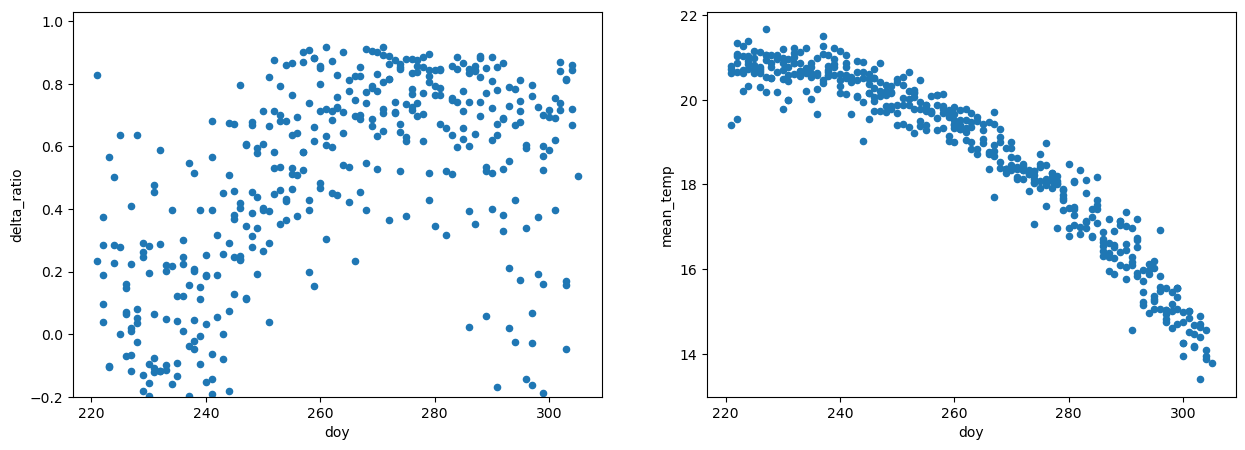

In [45]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 5))
_hanford_chinook_df[(_hanford_chinook_df["run"] == "fall") & (_hanford_chinook_df["year"] >= 1985)].plot.scatter(
        x="doy",
        y="delta_ratio",
        ax=ax,
        # c='group_5_year',
        # cmap='viridis'
)
# for group_5 in _hanford_chinook_df["group_5_year"].unique():
#     _hanford_chinook_df[(_hanford_chinook_df["run"] == "fall") & (_hanford_chinook_df['group_5_year']==group_5)].plot.scatter(
#         x="mean_temp",
#         y="delta_ratio",
#         ax=ax,
#         label=group_5,
#         c='year',
#         # cmap='viridis'
#     )
# ax.set_xlabel("Mean Temperature (C)")
# ax.set_ylabel("Change in Chinook Population")
# 1-1 line
# x = np.linspace(0, 1e6, 100)
# ax.plot(x, x, color='red')
ax.set_ylim(-.2, 1.03)

_hanford_chinook_df[(_hanford_chinook_df["run"] == "fall") & (_hanford_chinook_df["year"] >= 1965)].plot.scatter(
        x="doy",
        y="mean_temp",
        ax=ax2,
        # c='group_5_year',
        # cmap='viridis'
)


<Axes: xlabel='doy', ylabel='delta'>

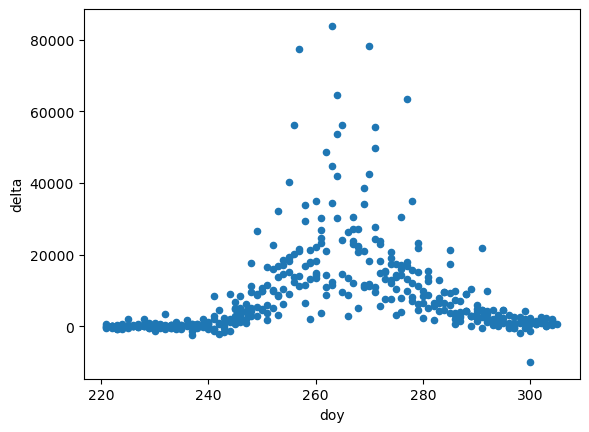

In [46]:
fig, ax = plt.subplots()
_hanford_chinook_df[(_hanford_chinook_df["run"] == "fall") & (_hanford_chinook_df["year"] >= 1985)].plot.scatter(
        x="doy",
        y="delta",
        ax=ax,
        # c='group_5_year',
        # cmap='viridis'
)

In [47]:
# find mean, median, mode, 5th, 25th, 75th, and 95th percentiles for each 5-year group
central_tendencies = _hanford_chinook_df[(_hanford_chinook_df["run"] == "fall")].groupby('group_5_year').agg(
    mean_delta_ratio=('delta_ratio', 'mean'),
    median_delta_ratio=('delta_ratio', 'median'),
    mode_delta_ratio=('delta_ratio', lambda x: x.mode().iloc[0]),
    p5_delta_ratio=('delta_ratio', lambda x: x.quantile(.05)),
    p25_delta_ratio=('delta_ratio', lambda x: x.quantile(.25)),
    p75_delta_ratio=('delta_ratio', lambda x: x.quantile(.75)),
    p95_delta_ratio=('delta_ratio', lambda x: x.quantile(.95)),
    mean_mean_temp=('mean_temp', 'mean'),
    median_mean_temp=('mean_temp', 'median'),
    # mode_mean_temp=('mean_temp', lambda x: x.mode().iloc[0]),
    p5_mean_temp=('mean_temp', lambda x: x.quantile(.05)),
    p25_mean_temp=('mean_temp', lambda x: x.quantile(.25)),
    p75_mean_temp=('mean_temp', lambda x: x.quantile(.75)),
    p95_mean_temp=('mean_temp', lambda x: x.quantile(.95)),
    n_samples = ('delta_ratio', 'count'),
    mcnary_sum = ('mcnary', 'sum'),
    priest_rapids_sum = ('priest_rapids', 'sum'),
    prosser_sum = ('prosser', 'sum'),
    ice_harbor_sum = ('ice_harbor', 'sum'),
).reset_index()

# mean_temp_central_tendencies = _hanford_chinook_df[(_hanford_chinook_df["run"] == "fall")].groupby('group_5_year').agg(
#     mean_mean_temp=('mean_temp', 'mean'),
#     median_mean_temp=('mean_temp', 'median'),
#     mode_mean_temp=('mean_temp', lambda x: x.mode().iloc[0]),
#     p5_mean_temp=('mean_temp', lambda x: x.quantile(.05)),
#     p25_mean_temp=('mean_temp', lambda x: x.quantile(.25)),
#     p75_mean_temp=('mean_temp', lambda x: x.quantile(.75)),
#     p95_mean_temp=('mean_temp', lambda x: x.quantile(.95)),
# ).reset_index()

# del_r_central_tendencies.to_csv("del_r_central_tendencies.csv", index=False)
# mean_temp_central_tendencies.to_csv("mean_temp_central_tendencies.csv", index=False)


In [48]:
central_tendencies['yearly_delta'] = central_tendencies['mcnary_sum'] - central_tendencies['priest_rapids_sum'] - central_tendencies['prosser_sum'] - central_tendencies['ice_harbor_sum']
central_tendencies['yearly_delta_ratio'] = central_tendencies['yearly_delta'] / central_tendencies['mcnary_sum']

In [49]:
central_tendencies

,group_5_year,mean_delta_ratio,median_delta_ratio,mode_delta_ratio,p5_delta_ratio,p25_delta_ratio,p75_delta_ratio,p95_delta_ratio,mean_mean_temp,median_mean_temp,...,p25_mean_temp,p75_mean_temp,p95_mean_temp,n_samples,mcnary_sum,priest_rapids_sum,prosser_sum,ice_harbor_sum,yearly_delta,yearly_delta_ratio
0,1985,0.612190,0.606803,0.188470,0.217697,0.299608,0.866849,0.911300,18.651814,18.722500,...,17.509000,20.622500,21.075176,9,164423.0,19644.0,87.0,4153.0,140539.0,0.854741
1,1986,0.711022,0.775948,0.122269,0.334631,0.649836,0.869556,0.893686,18.809441,19.376127,...,18.312672,19.954167,20.359882,10,183399.0,33259.0,0.0,7993.0,142147.0,0.775070
2,1987,0.755472,0.795981,0.408468,0.512895,0.679726,0.860348,0.882123,18.207840,18.985000,...,17.343333,20.131111,20.199529,9,93470.0,17779.0,0.0,3635.0,72056.0,0.770900
3,1988,0.781759,0.810772,0.588403,0.610295,0.755789,0.846041,0.873561,18.775000,19.052235,...,17.369952,20.327904,20.621316,10,107960.0,15034.0,0.0,5582.0,87344.0,0.809040
4,1989,0.726149,0.803919,0.475485,0.487010,0.554763,0.870123,0.879375,18.866979,19.668750,...,18.518676,20.121667,20.467941,10,73105.0,7622.0,0.0,4509.0,60974.0,0.834061
5,1990,0.696984,0.790947,0.194492,0.371358,0.619937,0.828850,0.852960,18.451969,18.970000,...,17.276405,20.149353,21.101324,11,62383.0,6807.0,0.0,4725.0,50851.0,0.815142
6,1991,0.599518,0.701331,0.039216,0.122952,0.481554,0.797665,0.863100,18.253441,18.836691,...,17.332206,19.637500,19.988088,10,55562.0,6115.0,1371.0,4587.0,43489.0,0.782711
7,1992,0.705372,0.808989,0.224981,0.310832,0.621788,0.855888,0.889239,18.426085,19.232353,...,17.286275,20.035857,20.792778,11,60506.0,7797.0,892.0,2921.0,48896.0,0.808118
8,1993,0.624680,0.769623,0.064693,0.133004,0.423970,0.870000,0.914049,18.636211,19.497500,...,17.408750,20.226806,20.545882,11,98832.0,13768.0,1280.0,2661.0,81123.0,0.820817
9,1994,0.645105,0.751660,0.289312,0.326686,0.414220,0.842107,0.857967,18.485597,19.359438,...,16.764125,20.174912,20.928676,8,64399.0,14140.0,791.0,3204.0,46264.0,0.718396


In [50]:
central_tendencies.to_csv("hanford_central_tendencies.csv", index=False)

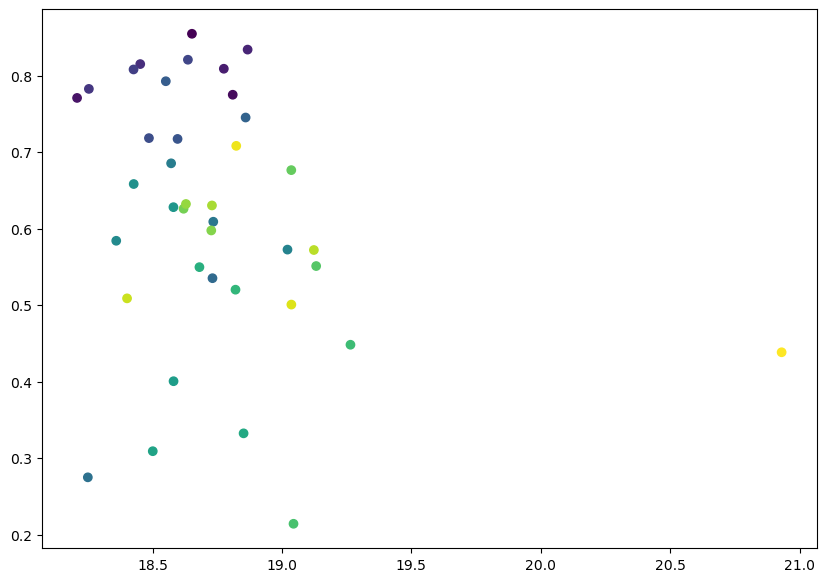

In [51]:
fig, ax = plt.subplots(figsize=(10, 7)) 
# central_tendencies.plot(x="mean_mean_temp", y="mean_delta_ratio", kind="scatter")
# ax.scatter(central_tendencies["mean_mean_temp"], central_tendencies["mean_delta_ratio"], c=central_tendencies["group_5_year"].astype(int), cmap='viridis')
ax.scatter(central_tendencies["mean_mean_temp"], central_tendencies["yearly_delta_ratio"], c=central_tendencies["group_5_year"].astype(int), cmap='viridis')

# zip joins x and y coordinates in pairs
for x,y,group in zip(central_tendencies["mean_mean_temp"], central_tendencies["mean_delta_ratio"],  central_tendencies["group_5_year"]):

    label = "{}".format(group)

    # plt.annotate(label, # this is the text
    #              (x,y), # these are the coordinates to position the label
    #              textcoords="offset points", # how to position the text
    #              xytext=(0,10), # distance from text to points (x,y)
    #              ha='center') # horizontal alignment can be left, right or center
    
# add a horizontal wisker for the 5th, 25th, 75th, and 95th percentiles
# ax.errorbar(
#     central_tendencies["mean_mean_temp"],
#     central_tendencies["mean_delta_ratio"],
#     # yerr=[
#     #     central_tendencies["mean_delta_ratio"] - central_tendencies["p5_delta_ratio"],
#     #     central_tendencies["p95_delta_ratio"] - central_tendencies["mean_delta_ratio"],
#     # ],
#     xerr=[
#         central_tendencies["mean_mean_temp"] - central_tendencies["p25_mean_temp"],
#         central_tendencies["p75_mean_temp"] - central_tendencies["mean_mean_temp"],
#     ],
#     fmt="o",
#     color="black",
# )

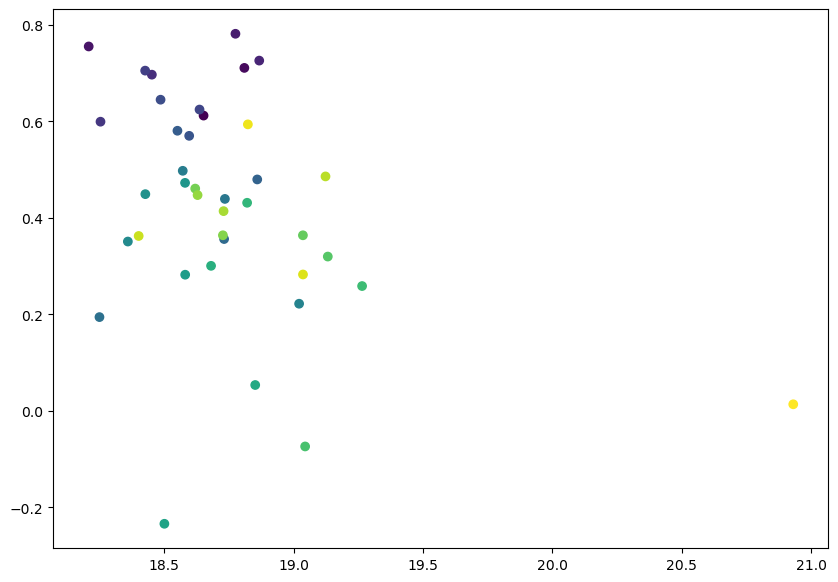

In [52]:
fig, ax = plt.subplots(figsize=(10, 7)) 
# central_tendencies.plot(x="mean_mean_temp", y="mean_delta_ratio", kind="scatter")
ax.scatter(central_tendencies["mean_mean_temp"], central_tendencies["mean_delta_ratio"], c=central_tendencies["group_5_year"].astype(int), cmap='viridis')
# ax.scatter(central_tendencies["mean_mean_temp"], central_tendencies["yearly_delta_ratio"], c=central_tendencies["group_5_year"].astype(int), cmap='viridis')

# zip joins x and y coordinates in pairs
for x,y,group in zip(central_tendencies["mean_mean_temp"], central_tendencies["mean_delta_ratio"],  central_tendencies["group_5_year"]):

    label = "{}".format(group)

    # plt.annotate(label, # this is the text
    #              (x,y), # these are the coordinates to position the label
    #              textcoords="offset points", # how to position the text
    #              xytext=(0,10), # distance from text to points (x,y)
    #              ha='center') # horizontal alignment can be left, right or center
    
# add a horizontal wisker for the 5th, 25th, 75th, and 95th percentiles
# ax.errorbar(
#     central_tendencies["mean_mean_temp"],
#     central_tendencies["mean_delta_ratio"],
#     # yerr=[
#     #     central_tendencies["mean_delta_ratio"] - central_tendencies["p5_delta_ratio"],
#     #     central_tendencies["p95_delta_ratio"] - central_tendencies["mean_delta_ratio"],
#     # ],
#     xerr=[
#         central_tendencies["mean_mean_temp"] - central_tendencies["p25_mean_temp"],
#         central_tendencies["p75_mean_temp"] - central_tendencies["mean_mean_temp"],
#     ],
#     fmt="o",
#     color="black",
# )

<Axes: xlabel='date'>

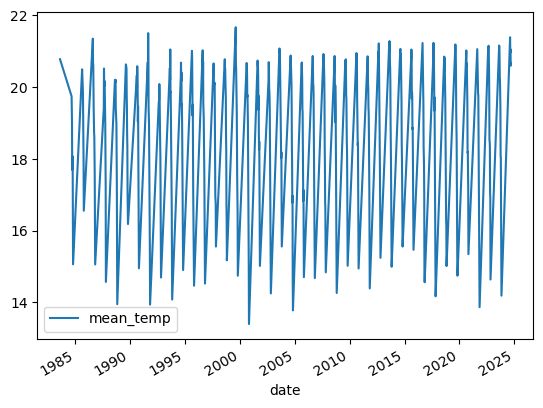

In [53]:
fig, ax = plt.subplots()
_hanford_chinook_df[_hanford_chinook_df["run"] == "fall"].plot(
    x="date",
    y="mean_temp",
    ax=ax,
    # c='year',
    # cmap='viridis'
)
# _hanford_chinook_df[_hanford_chinook_df["run"] == "fall"].plot(
#     x="date",
#     y="delta_ratio",
#     ax=ax,
#     # c='year',
#     # cmap='viridis'
# )
# ax.set_xlabel("Mean Temperature (C)")
# ax.set_ylabel("Change in Chinook Population")
# 1-1 line
# x = np.linspace(0, 1e6, 100)
# ax.plot(x, x, color='red')


# Swimming speed assessment

In [81]:
mcn_pittag = pd.read_csv(proj_dir/ "data/insitu/fish/pit_tag/adult/MCN.csv")[["Tag ID", "SpRRT", "Mark Site", "Release Site", "Release Date", "Obs Site", "Obs Time", "Travel Days"]].copy()
prd_pittag = pd.read_csv(proj_dir/ "data/insitu/fish/pit_tag/adult/PRD.csv")[["Tag ID", "SpRRT", "Mark Site", "Release Site", "Release Date", "Obs Site", "Obs Time", "Travel Days"]].copy()

/var/folders/0q/tm370x9d1qdg6nt3w7pcqh_w0000gq/T/ipykernel_60290/1346497990.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  mcn_pittag = pd.read_csv(proj_dir/ "data/insitu/fish/pit_tag/adult/MCN.csv")[["Tag ID", "SpRRT", "Mark Site", "Release Site", "Release Date", "Obs Site", "Obs Time", "Travel Days"]].copy()


In [117]:
mcn_prd_pittag = mcn_pittag.merge(prd_pittag, on="Tag ID", how="inner", suffixes=("_mcn", "_prd"))

In [118]:
mcn_prd_pittag.columns

Index(['Tag ID', 'SpRRT_mcn', 'Mark Site_mcn', 'Release Site_mcn',
       'Release Date_mcn', 'Obs Site_mcn', 'Obs Time_mcn', 'Travel Days_mcn',
       'SpRRT_prd', 'Mark Site_prd', 'Release Site_prd', 'Release Date_prd',
       'Obs Site_prd', 'Obs Time_prd', 'Travel Days_prd'],
      dtype='object')

In [122]:
mcn_prd_pittag['speed'] = 1 / (mcn_prd_pittag["Travel Days_prd"] - mcn_prd_pittag["Travel Days_mcn"])
mcn_prd_pittag['year'] = pd.to_datetime(mcn_prd_pittag["Obs Time_mcn"]).dt.year
mcn_prd_pittag['date'] = pd.to_datetime(mcn_prd_pittag["Obs Time_mcn"])
mcn_prd_pittag['days_from_fall'] = (mcn_prd_pittag['date'] - pd.to_datetime(mcn_prd_pittag['year'].astype(str) + f"-{run_schedules['mcnary']['fall'][0]}")).dt.days + 1
mcn_prd_pittag = mcn_prd_pittag[(mcn_prd_pittag["days_from_fall"] >= 0) & (mcn_prd_pittag["days_from_fall"] <= 80)].copy()

In [123]:
print(mcn_prd_pittag['date'].max())
print(mcn_prd_pittag['date'].min())

2024-10-13 12:28:00
2003-08-08 06:52:00


<Axes: xlabel='days_from_fall', ylabel='speed'>

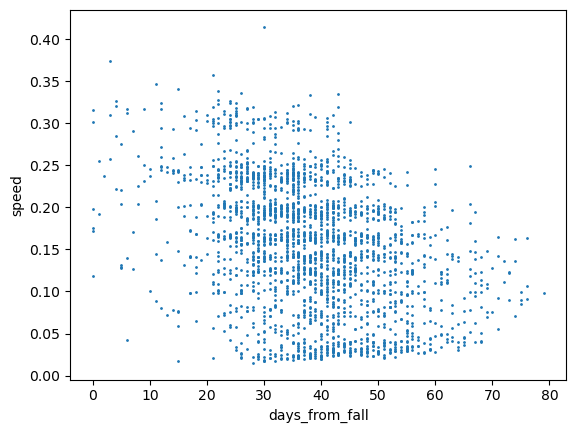

In [124]:
mcn_prd_pittag.plot(x="days_from_fall", y="speed", kind="scatter", marker='o', s=1)

In [125]:
np.arange(0, 0.45, 0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ])

In [92]:
# bin the mcn_prd_pittag data by speed
mcn_prd_pittag['speed_bin'] = pd.cut(mcn_prd_pittag['speed'], bins=np.arange(0, 0.45, 0.05), labels=[f"{x}-{x+0.05}" for x in np.arange(0, 0.45, 0.05)][:-1])

In [113]:
mcn_prd_pittag['speed_bin_mid'] = mcn_prd_pittag['speed_bin'].apply(lambda x: (float(x.split('-')[0]) + float(x.split('-')[1])) / 2)
mcn_prd_pittag.to_csv("mcn_prd_pittag.csv", index=False)

In [104]:
mcn_prd_pittag_binned = mcn_prd_pittag.groupby('speed_bin').agg(
    mean_speed=('speed', 'mean'),
    median_speed=('speed', 'median'),
    mode_speed=('speed', lambda x: x.mode().iloc[0]),
    p5_speed=('speed', lambda x: x.quantile(.05)),
    p25_speed=('speed', lambda x: x.quantile(.25)),
    p75_speed=('speed', lambda x: x.quantile(.75)),
    p95_speed=('speed', lambda x: x.quantile(.95)),
    days_from_fall=('days_from_fall', 'mean'),
    p25_days_from_fall=('days_from_fall', lambda x: x.quantile(.25)),
    p75_days_from_fall=('days_from_fall', lambda x: x.quantile(.75)),
    n_samples = ('speed', 'count'),
)

<ErrorbarContainer object of 3 artists>

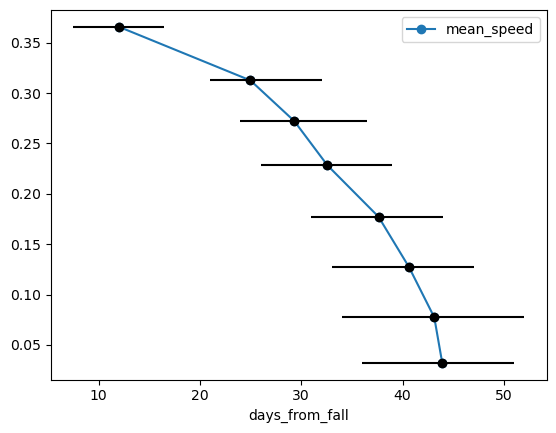

In [115]:
fig, ax = plt.subplots()
mcn_prd_pittag_binned.plot(x="days_from_fall", y="mean_speed", marker='o', ax=ax)
# add a horizontal wisker for the 25th, 75th percentiles of days from fall
ax.errorbar(
    mcn_prd_pittag_binned["days_from_fall"],
    mcn_prd_pittag_binned["mean_speed"],
    xerr=[
        mcn_prd_pittag_binned["days_from_fall"] - mcn_prd_pittag_binned["p25_days_from_fall"],
        mcn_prd_pittag_binned["p75_days_from_fall"] - mcn_prd_pittag_binned["days_from_fall"],
    ],
    fmt="o",
    color="black",
)

In [116]:
mcn_prd_pittag_binned.to_csv("mcn_prd_pittag_binned.csv", index=False)

## Wannapum to Rock Island

In [266]:
wannapum_chinook_df = wan_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()
rock_island_chinook_df = ris_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()

In [267]:
wan_ris_chinook_df = (
    wannapum_chinook_df[(wannapum_chinook_df["run"] == "fall")][["date", "chinook"]]
    .rename(columns={"chinook": "wannapum"})
    .merge(
        rock_island_chinook_df[(rock_island_chinook_df["run"] == "fall")][
            ["date", "chinook"]
        ].rename(columns={"chinook": "rock_island"}),
        on="date",
        how="outer",
    )
)

wan_ris_chinook_df["year"] = wan_ris_chinook_df["date"].dt.year
wan_ris_chinook_df[["wannapum", "rock_island"]] = (
    wan_ris_chinook_df[["wannapum", "rock_island"]].copy().fillna(0)
)
wan_ris_chinook_df["delta"] = (
    wan_ris_chinook_df["wannapum"] - wan_ris_chinook_df["rock_island"]
)
wan_ris_chinook_df.dropna(subset=["year"], inplace=True)

In [268]:
_wan_ris_chinook_df = wan_ris_chinook_df.resample("W", on="date").sum().reset_index()

In [269]:
_wan_ris_temp_df = _merged_columbia[range(670, 720, 10)].reset_index()
_wan_ris_temp_df["mean_temp"] = _wan_ris_temp_df.drop(columns=["date"]).mean(axis=1)
_wan_ris_chinook_df = _wan_ris_chinook_df.merge(_wan_ris_temp_df, on="date", how="left")
_wan_ris_chinook_df = allocate_runs(_wan_ris_chinook_df, run_schedules["rock_island"])

In [270]:
_wan_ris_chinook_df["delta_ratio"] = (
    _wan_ris_chinook_df["delta"] / _wan_ris_chinook_df["wannapum"]
)

_wan_ris_chinook_df.dropna(subset=["mean_temp", "delta"]).to_csv(
    "wan_ris_chinook_mass_bal.csv", index=False
)

In [278]:
# assign 5-year categories from 2000 to 2022
interval = 5
_wan_ris_chinook_df["group_5_year"] = pd.cut(
    _wan_ris_chinook_df["year"],
    bins=range(1977, 2026, interval),
    labels=[f"{x}-{x+interval-1}" for x in range(1977, 2026, interval)][:-1],
)

In [279]:
wan_ris_central_tendencies = _wan_ris_chinook_df[(_wan_ris_chinook_df["run"] == "fall")].groupby('group_5_year').agg(
    mean_delta_ratio=('delta_ratio', 'mean'),
    median_delta_ratio=('delta_ratio', 'median'),
    mode_delta_ratio=('delta_ratio', lambda x: x.mode().iloc[0]),
    p5_delta_ratio=('delta_ratio', lambda x: x.quantile(.05)),
    p25_delta_ratio=('delta_ratio', lambda x: x.quantile(.25)),
    p75_delta_ratio=('delta_ratio', lambda x: x.quantile(.75)),
    p95_delta_ratio=('delta_ratio', lambda x: x.quantile(.95)),
    mean_mean_temp=('mean_temp', 'mean'),
    median_mean_temp=('mean_temp', 'median'),
    # mode_mean_temp=('mean_temp', lambda x: x.mode().iloc[0]),
    p5_mean_temp=('mean_temp', lambda x: x.quantile(.05)),
    p25_mean_temp=('mean_temp', lambda x: x.quantile(.25)),
    p75_mean_temp=('mean_temp', lambda x: x.quantile(.75)),
    p95_mean_temp=('mean_temp', lambda x: x.quantile(.95)),
    n_samples = ('delta_ratio', 'count')
).reset_index()

<Axes: xlabel='mean_mean_temp', ylabel='mean_delta_ratio'>

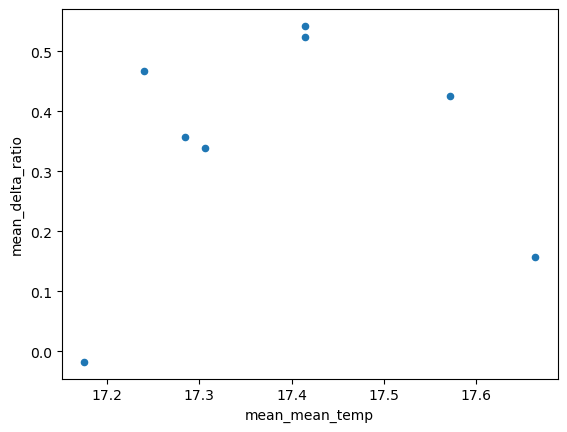

In [280]:
wan_ris_central_tendencies.plot(x="mean_mean_temp", y="mean_delta_ratio", kind="scatter")

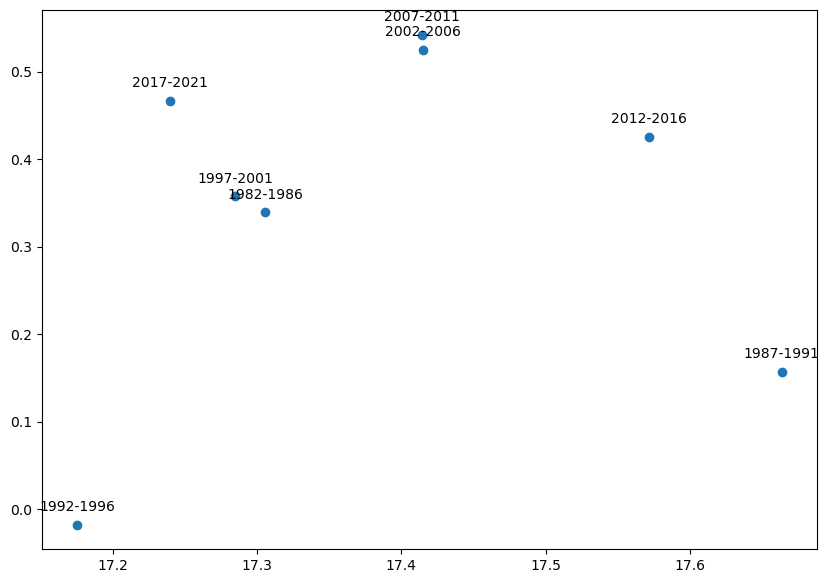

In [281]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(wan_ris_central_tendencies["mean_mean_temp"], wan_ris_central_tendencies["mean_delta_ratio"])

# zip joins x and y coordinates in pairs
for x,y,group in zip(wan_ris_central_tendencies["mean_mean_temp"], wan_ris_central_tendencies["mean_delta_ratio"],  wan_ris_central_tendencies["group_5_year"]):

    label = "{}".format(group)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

## Ice Harbor to Lower Monumental

In [285]:
ice_harbor_chinook_df = ihr_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()
lower_monumental_chinook_df = lmn_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].copy()

In [286]:
ihr_lmn_chinook_df = (
    ice_harbor_chinook_df[(ice_harbor_chinook_df["run"] == "fall")][["date", "chinook"]]
    .rename(columns={"chinook": "ice_harbor"})
    .merge(
        lower_monumental_chinook_df[(lower_monumental_chinook_df["run"] == "fall")][
            ["date", "chinook"]
        ].rename(columns={"chinook": "lower_monumental"}),
        on="date",
        how="outer",
    )
)

ihr_lmn_chinook_df["year"] = ihr_lmn_chinook_df["date"].dt.year
ihr_lmn_chinook_df[["ice_harbor", "lower_monumental"]] = (
    ihr_lmn_chinook_df[["ice_harbor", "lower_monumental"]].copy().fillna(0)
)
ihr_lmn_chinook_df["delta"] = (
    ihr_lmn_chinook_df["ice_harbor"] - ihr_lmn_chinook_df["lower_monumental"]
)
ihr_lmn_chinook_df.dropna(subset=["year"], inplace=True)

In [288]:
_ihr_lmn_chinook_df = ihr_lmn_chinook_df.resample("W", on="date").sum().reset_index()

In [289]:
_ihr_lmn_temp_df = _merged_snake[range(20, 50, 10)].reset_index()
_ihr_lmn_temp_df["mean_temp"] = _ihr_lmn_temp_df.drop(columns=["date"]).mean(axis=1)
_ihr_lmn_chinook_df = _ihr_lmn_chinook_df.merge(_ihr_lmn_temp_df, on="date", how="left")
_ihr_lmn_chinook_df = allocate_runs(_ihr_lmn_chinook_df, run_schedules["rock_island"])

In [291]:
_ihr_lmn_chinook_df["delta_ratio"] = (
    _ihr_lmn_chinook_df["delta"] / _ihr_lmn_chinook_df["ice_harbor"]
)

_ihr_lmn_chinook_df.dropna(subset=["mean_temp", "delta"]).to_csv(
    "ihr_lmn_chinook_mass_bal.csv", index=False
)

In [299]:
# assign 5-year categories from 2000 to 2022
interval = 5
_ihr_lmn_chinook_df["group_5_year"] = pd.cut(
    _ihr_lmn_chinook_df["year"],
    bins=range(1985, 2026, interval),
    labels=[f"{x}-{x+interval-1}" for x in range(1985, 2026, interval)][:-1],
)

In [300]:
ihr_lmn_central_tendencies = _ihr_lmn_chinook_df[(_ihr_lmn_chinook_df["run"] == "fall")].groupby('group_5_year').agg(
    mean_delta_ratio=('delta_ratio', 'mean'),
    median_delta_ratio=('delta_ratio', 'median'),
    mode_delta_ratio=('delta_ratio', lambda x: x.mode().iloc[0]),
    p5_delta_ratio=('delta_ratio', lambda x: x.quantile(.05)),
    p25_delta_ratio=('delta_ratio', lambda x: x.quantile(.25)),
    p75_delta_ratio=('delta_ratio', lambda x: x.quantile(.75)),
    p95_delta_ratio=('delta_ratio', lambda x: x.quantile(.95)),
    mean_mean_temp=('mean_temp', 'mean'),
    median_mean_temp=('mean_temp', 'median'),
    # mode_mean_temp=('mean_temp', lambda x: x.mode().iloc[0]),
    p5_mean_temp=('mean_temp', lambda x: x.quantile(.05)),
    p25_mean_temp=('mean_temp', lambda x: x.quantile(.25)),
    p75_mean_temp=('mean_temp', lambda x: x.quantile(.75)),
    p95_mean_temp=('mean_temp', lambda x: x.quantile(.95)),
    n_samples = ('delta_ratio', 'count')
).reset_index()

<Axes: xlabel='mean_mean_temp', ylabel='mean_delta_ratio'>

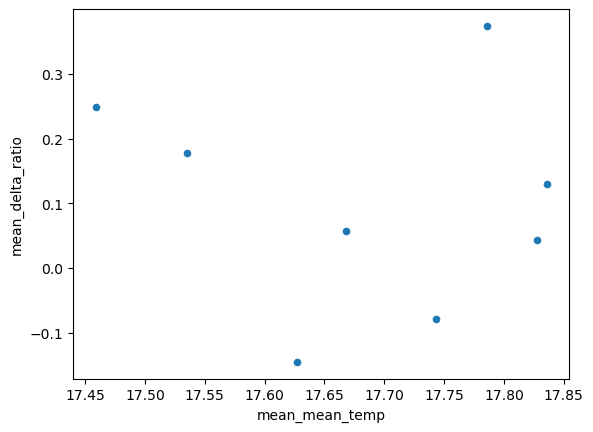

In [301]:
ihr_lmn_central_tendencies.plot(x="mean_mean_temp", y="mean_delta_ratio", kind="scatter")

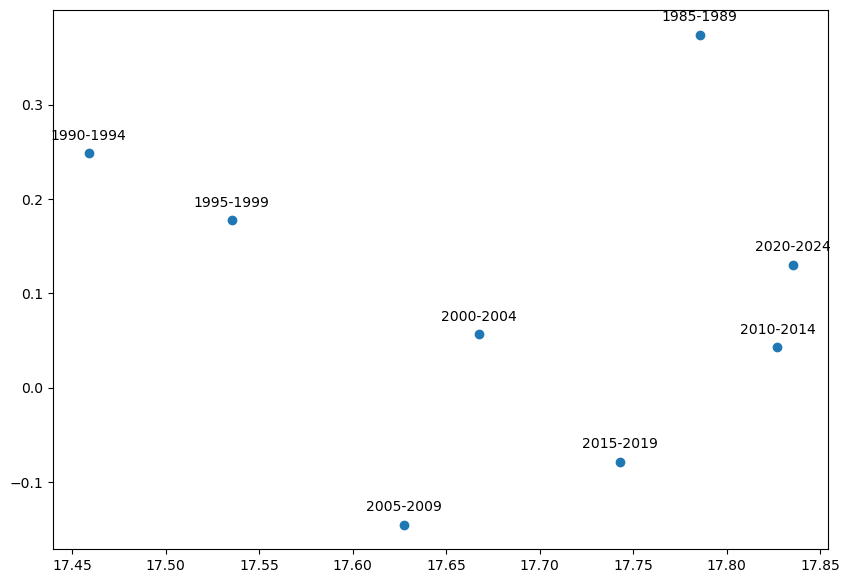

In [302]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(ihr_lmn_central_tendencies["mean_mean_temp"], ihr_lmn_central_tendencies["mean_delta_ratio"])

# zip joins x and y coordinates in pairs
for x,y,group in zip(ihr_lmn_central_tendencies["mean_mean_temp"], ihr_lmn_central_tendencies["mean_delta_ratio"],  ihr_lmn_central_tendencies["group_5_year"]):

    label = "{}".format(group)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [303]:

ihr_lmn_central_tendencies.to_csv("ihr_lmn_central_tendencies.csv", index=False)

## Snake River
Ice Harbor - Lower Monumental - Little Goose

In [126]:
ihr_chinook_df = ihr_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].dropna(subset=["chinook",]).copy()
lmn_chinook_df = lmn_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].dropna(subset=["chinook",]).copy()
lgs_chinook_df = lgs_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].dropna(subset=["chinook",]).copy()
lwg_chinook_df = lwg_fish_df[
    ["date", "year", "month", "day", "chinook", "run", "avg_temp(C)"]
].dropna(subset=["chinook",]).copy()

In [127]:
ihr_lwg_chinook_df = (
    ihr_chinook_df[(ihr_chinook_df["run"] == "fall")][["date", "chinook"]]
    .rename(columns={"chinook": "ihr"})
    .merge(
        lmn_chinook_df[(lmn_chinook_df["run"] == "fall")][["date", "chinook"]].rename(
            columns={"chinook": "lmn"}
        ),
        on="date",
        how="outer",
    )
    .merge(
        lgs_chinook_df[(lgs_chinook_df["run"] == "fall")][["date", "chinook"]].rename(
            columns={"chinook": "lgs"}
        ),
        on="date",
        how="outer",
    )
    .merge(
        lwg_chinook_df[(lwg_chinook_df["run"] == "fall")][["date", "chinook"]].rename(
            columns={"chinook": "lwg"}
        ),
        on="date",
        how="outer",
    )
    .copy()
)
ihr_lwg_chinook_df["year"] = ihr_lwg_chinook_df["date"].dt.year
ihr_lwg_chinook_df[["ihr", "lmn", "lgs", "lwg"]] = (
    ihr_lwg_chinook_df[["ihr", "lmn", "lgs", "lwg"]].copy().fillna(0)
)
ihr_lwg_chinook_df["ihr_lmn_delta"] = (
    ihr_lwg_chinook_df["ihr"] - ihr_lwg_chinook_df["lmn"]
)
# ihr_lwg_chinook_df["ihr_lmn_delta_ratio"] = (
#     ihr_lwg_chinook_df["ihr_lmn_delta"] / ihr_lwg_chinook_df["ihr"]
# )

ihr_lwg_chinook_df["lmn_lgs_delta"] = (
    ihr_lwg_chinook_df["lmn"] - ihr_lwg_chinook_df["lgs"]
)
# ihr_lwg_chinook_df["lmn_lgs_delta_ratio"] = (
#     ihr_lwg_chinook_df["lmn_lgs_delta"] / ihr_lwg_chinook_df["lmn"]
# )

ihr_lwg_chinook_df["lgs_lwg_delta"] = (
    ihr_lwg_chinook_df["lgs"] - ihr_lwg_chinook_df["lwg"]
)
# ihr_lwg_chinook_df["lgs_lwg_delta_ratio"] = (
#     ihr_lwg_chinook_df["lgs_lwg_delta"] / ihr_lwg_chinook_df["lgs"]
# )
ihr_lwg_chinook_df.dropna(subset=["year"], inplace=True)

In [128]:
ihr_lwg_chinook_df["ihr_lmn_delta"] / ihr_lwg_chinook_df["ihr"]

0       1.000000
1       1.000000
2      -6.000000
3       0.000000
4       0.428571
          ...   
6522         NaN
6523         NaN
6524         NaN
6525         NaN
6526         NaN
Length: 6527, dtype: float64

In [129]:
ihr_lwg_chinook_df_weekly = ihr_lwg_chinook_df.resample("W", on="date").sum(numeric_only=True).reset_index()

In [130]:
ihr_lwg_chinook_df_weekly["ihr_lmn_delta_ratio"] = (
    ihr_lwg_chinook_df_weekly["ihr_lmn_delta"] / ihr_lwg_chinook_df_weekly["ihr"]
)
ihr_lwg_chinook_df_weekly["lmn_lgs_delta_ratio"] = (
    ihr_lwg_chinook_df_weekly["lmn_lgs_delta"] / ihr_lwg_chinook_df_weekly["lmn"]
)
ihr_lwg_chinook_df_weekly["lgs_lwg_delta_ratio"] = (
    ihr_lwg_chinook_df_weekly["lgs_lwg_delta"] / ihr_lwg_chinook_df_weekly["lgs"]
)


In [131]:
thorr_df = pd.read_csv(proj_dir / "data/thorr/thorr_temp.csv")
thorr_df["date"] = pd.to_datetime(thorr_df["Date"])
columbia_df = thorr_df[thorr_df["RiverID"] == 9].copy()
snake_df = thorr_df[thorr_df["RiverID"] == 45].copy()
yakima_df = thorr_df[thorr_df["RiverID"] == 58].copy()
# thorr_df = thorr_df[thorr_df['RiverID'] == 9].copy()

In [132]:
# group snake by reach
grouped_snake = snake_df.groupby("RKm")

_merged_snake = pd.DataFrame(columns=["date"])
for group in grouped_snake:
    resampled = group[1].resample("W", on="date").mean(numeric_only=True).reset_index()
    # print(resampled)
    resampled.rename(columns={"EstTempC": resampled["RKm"].iloc[0]}, inplace=True)
    _merged_snake = pd.merge(
        _merged_snake,
        resampled[["date", resampled["RKm"].iloc[0]]],
        on="date",
        how="outer",
    )

_merged_snake["date"] = pd.to_datetime(_merged_snake["date"])

# make date the index
_merged_snake.set_index("date", inplace=True)
# sort by date
_merged_snake.sort_index(inplace=True)

In [133]:
ihr_lmn_temp_df = _merged_snake[range(20, 50, 10)].reset_index()
ihr_lmn_temp_df["mean_temp_ihr_lmn"] = ihr_lmn_temp_df.drop(columns=["date"]).mean(axis=1)
lmn_lgs_temp_df = _merged_snake[range(70, 100, 10)].reset_index()
lmn_lgs_temp_df["mean_temp_lmn_lgs"] = lmn_lgs_temp_df.drop(columns=["date"]).mean(axis=1)
lgs_lwg_temp_df = _merged_snake[range(110, 140, 10)].reset_index()
lgs_lwg_temp_df["mean_temp_lgs_lwg"] = lgs_lwg_temp_df.drop(columns=["date"]).mean(axis=1)

ihr_lwg_chinook_df_weekly = ihr_lwg_chinook_df_weekly.merge(ihr_lmn_temp_df, on="date", how="left")
ihr_lwg_chinook_df_weekly = ihr_lwg_chinook_df_weekly.merge(lmn_lgs_temp_df, on="date", how="left")
ihr_lwg_chinook_df_weekly = ihr_lwg_chinook_df_weekly.merge(lgs_lwg_temp_df, on="date", how="left")

ihr_lwg_chinook_df_weekly = allocate_runs(ihr_lwg_chinook_df_weekly, run_schedules["ice_harbor"])

<Axes: xlabel='date'>

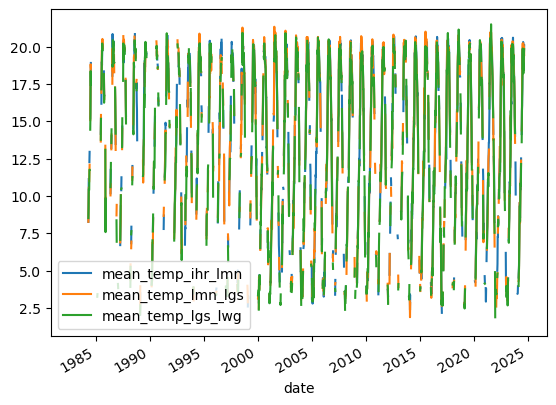

In [134]:
ihr_lwg_chinook_df_weekly.plot(x="date", y=["mean_temp_ihr_lmn", "mean_temp_lmn_lgs", "mean_temp_lgs_lwg"])

In [135]:
ihr_lwg_chinook_df_weekly['ihr_lmn_t_grad'] = ihr_lwg_chinook_df_weekly['mean_temp_ihr_lmn'] - ihr_lwg_chinook_df_weekly['mean_temp_lmn_lgs']
ihr_lwg_chinook_df_weekly['lmn_lgs_t_grad'] = ihr_lwg_chinook_df_weekly['mean_temp_lmn_lgs'] - ihr_lwg_chinook_df_weekly['mean_temp_lgs_lwg']

In [136]:
ihr_lwg_chinook_df_weekly.to_csv("ihr_lwg_chinook_df_weekly.csv", index=False)

In [139]:
ihr_lwg_chinook_df_weekly[["ihr_lmn_delta_ratio"]].dropna().min()

ihr_lmn_delta_ratio   -11.6
dtype: float64

<Axes: xlabel='date'>

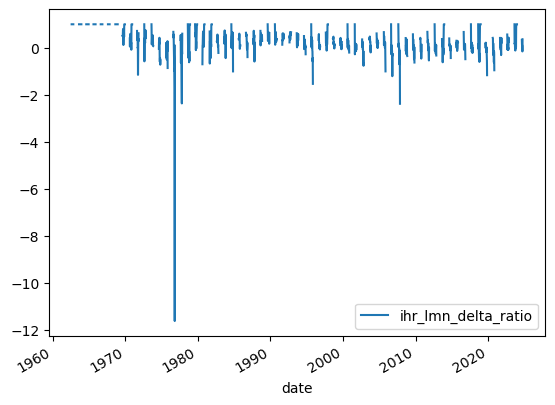

In [138]:
ihr_lwg_chinook_df_weekly.plot(x="date", y=["ihr_lmn_delta_ratio",])

In [143]:
ihr_lwg_chinook_df_weekly.dropna(subset=["ihr_lmn_delta_ratio", "ihr_lmn_t_grad"] ).to_csv("ihr_lmn_nona.csv", index=False)
ihr_lwg_chinook_df_weekly.dropna(subset=["lmn_lgs_delta_ratio", "lmn_lgs_t_grad"] ).to_csv("lmn_lgs_nona.csv", index=False)

## 